### This code uses images of chest x-rays to diagnose various lung diseases and maladies, as well as determine the presence of support devices.
The specific classes are:
<p>Enlarged Cardiomediastinum, Cardiomegaly, Lung Opacity, Lung Lesion, Edema, Consolidation, Pneumonia, Atelectasis,
Pneumothorax, Pleural Effusion, Pleural Other, Fracture, Support Devices</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print('Tensorflow version:',tf.__version__)
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,BatchNormalization,Flatten,Dropout,MaxPool2D,Dense
from keras.metrics import AUC,Accuracy
import random
import os
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')

Tensorflow version: 2.14.0


In [2]:
folder_path = os.path.join(Path.cwd(),r'OneDrive\Desktop\Datasets\lung-xrays')
label_path = os.path.join(folder_path,'image-label-dict.json')
image_label_dict = json.load(open(label_path,'r'))

patients_path = os.path.join(folder_path,'patients')
groups_paths = [os.path.join(patients_path,patientid) for patientid in os.listdir(patients_path)]

patients_paths = []
for group in groups_paths:
    patients = [os.path.join(group,p) for p in os.listdir(group)]
    patients_paths += patients

### The following function extracts the image from each image path and sets the shape as (512x512x1):

In [3]:
dim = 512

def extract_image(path):
    
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image,expand_animations=False)
    image.set_shape((dim,dim,1))
    image = tf.image.convert_image_dtype(image,tf.float32)
    
    return image

### Since there are often multiple x-rays from individual patients, the train/test split is done by patient rather than by images, so that images from one patient in the train data do not unduly influence images from that same patient in the test data. The training data has 61,313 patients, which total to 212,220 images and the test data has 3,227 patients which total to 11,194 images.

In [4]:
train_patients,test_patients = train_test_split(patients_paths,test_size=.05,random_state=9)

train_paths = []
train_labels = []

for patient_path in train_patients:
    image_names = os.listdir(patient_path)
    for image_name in image_names:
        image_path = os.path.join(patient_path,image_name)
        image_label = image_label_dict[image_name]
        train_paths.append(image_path)
        train_labels.append(image_label)
        
test_paths = []
test_labels = []

for patient_path in test_patients:
    image_names = os.listdir(patient_path)
    for image_name in image_names:
        image_path = os.path.join(patient_path,image_name)
        image_label = image_label_dict[image_name]
        test_paths.append(image_path)
        test_labels.append(image_label)
        
train_dict_path = os.path.join(folder_path,'train paths and labels.json')
train_dict = json.load(open(train_dict_path,'r'))
train_paths = list(train_dict.keys())
train_labels = list(train_dict.values())

test_dict_path = os.path.join(folder_path,'test paths and labels.json')
test_dict = json.load(open(test_dict_path,'r'))
test_paths = list(test_dict.keys())
test_labels = list(test_dict.values())

print('The training data consists of {} patients for a combined {} images.'.format(
    len(train_patients),
    len(train_paths)
))
print('The test data consists of {} patients for a combined {} images.'.format(
    len(test_patients),
    len(test_paths)
))

The training data consists of 61313 patients for a combined 212220 images.
The test data consists of 3227 patients for a combined 11194 images.


### The below chart shows the frequency of each of the various classes:


Classes: Enlarged Cardiomediastinum, Cardiomegaly, Lung Opacity, Lung Lesion, Edema, Consolidation, Pneumonia, Atelectasis, Pneumothorax, Pleural Effusion, Pleural Other, Fracture, Support Devices


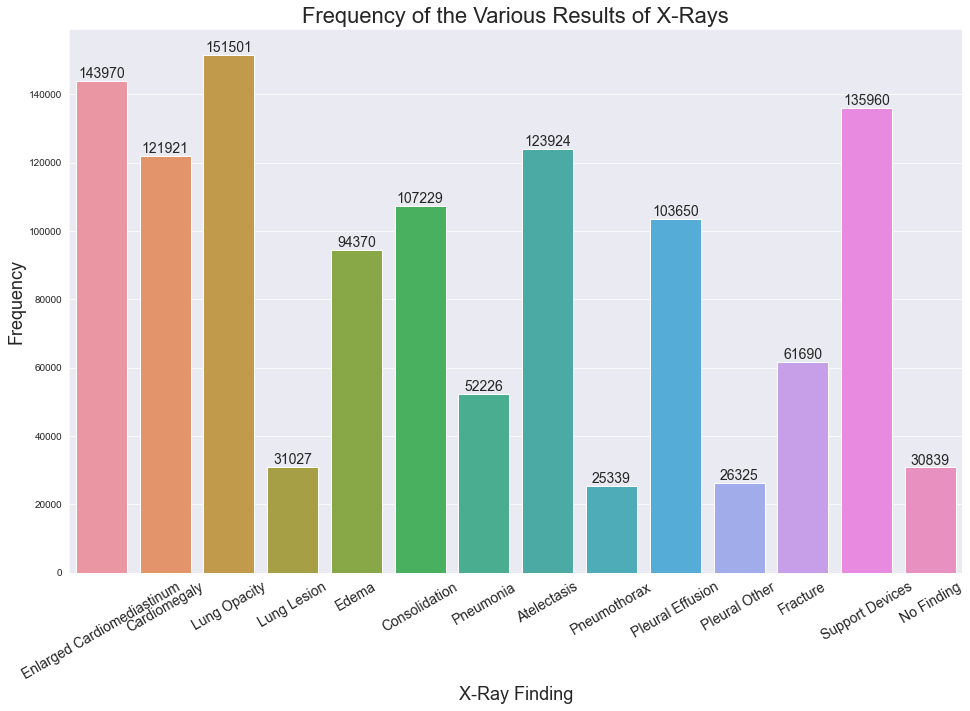

In [5]:
classes = ['Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema',
           'Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion',
           'Pleural Other','Fracture','Support Devices']
print('\nClasses:',', '.join(classes))

all_labels = np.vstack([train_labels,test_labels])
frequency_dict = {classes[i]:all_labels[:,i].sum() for i in range(len(classes))}
frequency_dict.setdefault('No Finding',len(np.where(all_labels.sum(axis=1)==0)[0]))

plt.figure(figsize=(16,10))
plot = sns.barplot(x=list(frequency_dict.keys()),y=list(frequency_dict.values()))
plot.bar_label(plot.containers[0],fontsize=14)
plt.xticks(rotation=30,fontsize=14)
plt.title('Frequency of the Various Results of X-Rays',fontdict={'fontsize':22})
plt.xlabel('X-Ray Finding',fontdict={'fontsize':18})
plt.ylabel('Frequency',fontdict={'fontsize':18})
plt.show()

### The function below turns the labels and paths into dataset objects for an efficient data pipeline. In addition to extracting the images and pairing them with labels, the function augments the training data by randomly flipping, rotating, and changing the brightness of the images in order to prevent overfitting.

In [6]:
batch_size = 64
random_rotation = keras.layers.RandomRotation(.04,fill_mode='constant',fill_value=0)
random_brightness = keras.layers.RandomBrightness(factor=.2,value_range=(0.,1))

def make_dataset(paths,labels,train=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((paths,labels))
    dataset = dataset.map(lambda x,y: (extract_image(x),y))
    if train:
        dataset = dataset.map(lambda x,y: (tf.image.random_flip_left_right(x),y))
        dataset = dataset.map(lambda x,y: (random_rotation(x),y))
        dataset = dataset.map(lambda x,y: (random_brightness(x),y))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = make_dataset(train_paths,train_labels)
test_dataset = make_dataset(test_paths,test_labels,False)

train_dataset.element_spec

(TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 13), dtype=tf.float32, name=None))

### The model uses convolutional and max pooling layers to extract the necessary features of the images, followed by a fully-connected classifier. The model was initially trained on a GPU for 60+ hours and the weights are uploaded here.

In [7]:
l2 = keras.regularizers.L2(1e-3)
dropout_rate = .1

def conv_block(X,filters,kernel_size=(5,5),l2=l2,dropout_rate=dropout_rate):
    
    X = Conv2D(filters,kernel_size,activation='relu',kernel_regularizer=l2)(X)
    X = BatchNormalization()(X)
    X = MaxPool2D(2)(X)
    X = Dropout(dropout_rate)(X)
    
    return X

inputs = keras.Input(shape=(dim,dim,1))
X = inputs

filters = 32
for i in range(6):
    X = conv_block(X,filters)
    filters *= 2
    
X = conv_block(X,filters,kernel_size=(3,3))
    
X = Flatten()(X)

for i in range(2):
    X = Dense(filters,activation='relu',kernel_regularizer=l2)(X)
    X = BatchNormalization()(X)
    X = Dropout(dropout_rate)(X)

outputs = Dense(len(classes),activation='sigmoid')(X)

model = keras.Model(inputs=inputs,
                   outputs=outputs)

optimizer = keras.optimizers.Adam(1e-5,epsilon=1e-2)
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=keras.metrics.AUC())

weights_path = os.path.join(folder_path,'xray-model-weights.h5')
model.load_weights(weights_path)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 508, 508, 32)      832       
                                                                 
 batch_normalization (Batch  (None, 508, 508, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 254, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 254, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      51264 

### Below are the metrics of the model. To measure success, I chose to use accuracy and AUC. While accuracy is often sufficient to judge a model's performance, but can be misleading in a case where classes are imbalanced, such as this. Therefore, the AUC metric is useful for showing how well the model differentiates between whether or not an outcome is positive. Regardless of class imbalance, a random guess will produce an AUC score of .5 and a perfect model will score 1.
### To test the model, I took a random sample of 2048 images from the train and test sets (using the whole datasets would be too big). The dataframe below displays the AUC and accuracy for each dataset.

In [8]:
test_sample_size = 2048

train_samples = random.sample(range(len(train_paths)),test_sample_size)
sample_train_labels = np.array(train_labels)[train_samples]
sample_train_ds = make_dataset(
    np.array(train_paths)[train_samples],
    sample_train_labels,
    False
)

test_samples = random.sample(range(len(test_paths)),test_sample_size)
sample_test_labels = np.array(test_labels)[test_samples]
sample_test_ds = make_dataset(
    np.array(test_paths)[test_samples],
    sample_test_labels,
    False
)

sample_train_pred = model.predict(sample_train_ds,verbose=0)
sample_test_pred = model.predict(sample_test_ds,verbose=0)

train_auc = AUC()(sample_train_labels,sample_train_pred).numpy()
train_accuracy = round(Accuracy()(sample_train_labels,sample_train_pred.round()).numpy()*100,2).astype('str')+'%'

test_auc = AUC()(sample_test_labels,sample_test_pred).numpy()
test_accuracy = round(Accuracy()(sample_test_labels,sample_test_pred.round()).numpy()*100,2).astype('str')+'%'


metrics_dict = {'AUC':[train_auc,test_auc],'Accuracy':[train_accuracy,test_accuracy]}

metrics_df = pd.DataFrame(metrics_dict,index=['Train Data','Test Data'])
metrics_df

,AUC,Accuracy
Train Data,0.992639,95.94%
Test Data,0.908044,84.19%


### After calculating the metrics across the entire datasets, I took the metrics for each category. 

In [9]:
all_train_auc = np.array([AUC()(sample_train_labels[:,i],sample_train_pred[:,i]) for i in range(len(classes))])
all_train_accuracy = np.round([Accuracy()(sample_train_labels[:,i],sample_train_pred[:,i].round())*100
                      for i in range(len(classes))],2)
all_train_accuracy = [str(n)+'%' for n in all_train_accuracy]

all_test_auc = np.array([AUC()(sample_test_labels[:,i],sample_test_pred[:,i]) for i in range(len(classes))])
all_test_accuracy = np.round([Accuracy()(sample_test_labels[:,i],sample_test_pred[:,i].round())*100
                             for i in range(len(classes))],2)
all_test_accuracy = [str(n)+'%' for n in all_test_accuracy]


train_df = pd.DataFrame(
    {classes[i]:[all_train_auc[i],all_train_accuracy[i]] for i in range(len(classes))},
    index=['AUC','Accuracy']
)

test_df = pd.DataFrame(
    {classes[i]:[all_test_auc[i],all_test_accuracy[i]] for i in range(len(classes))},
    index=['AUC','Accuracy']
)

print('Train reuslts:')
display(train_df)

print('\nTest results:')
display(test_df)

Train reuslts:


,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
AUC,0.992781,0.99204,0.996566,0.985605,0.992544,0.993511,0.984749,0.994795,0.989228,0.993491,0.991946,0.984628,0.986537
Accuracy,96.24%,95.26%,97.51%,96.63%,95.46%,95.75%,94.73%,96.39%,97.12%,96.04%,97.17%,94.48%,94.38%



Test results:


,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
AUC,0.903297,0.877751,0.921611,0.820476,0.871996,0.897974,0.81404,0.900107,0.830845,0.895091,0.827641,0.823561,0.913159
Accuracy,83.94%,79.49%,85.69%,89.26%,79.59%,82.28%,81.84%,82.28%,90.67%,82.37%,90.28%,81.98%,84.86%


### Here are a few examples of what the model does with images. Each randomly sampled image is next to a barplot; the title of the plot is the correct label, and the barplot shows how confident the model is that any given class is positive.
### The cell below takes images from the training data:

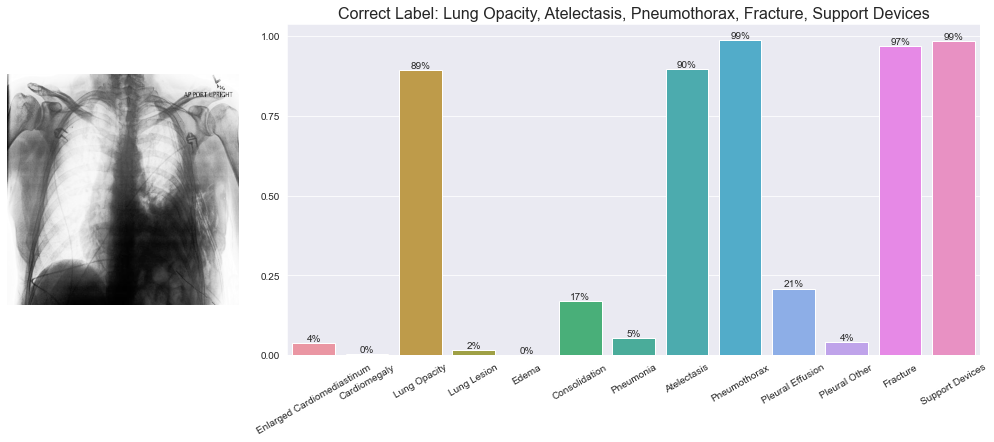

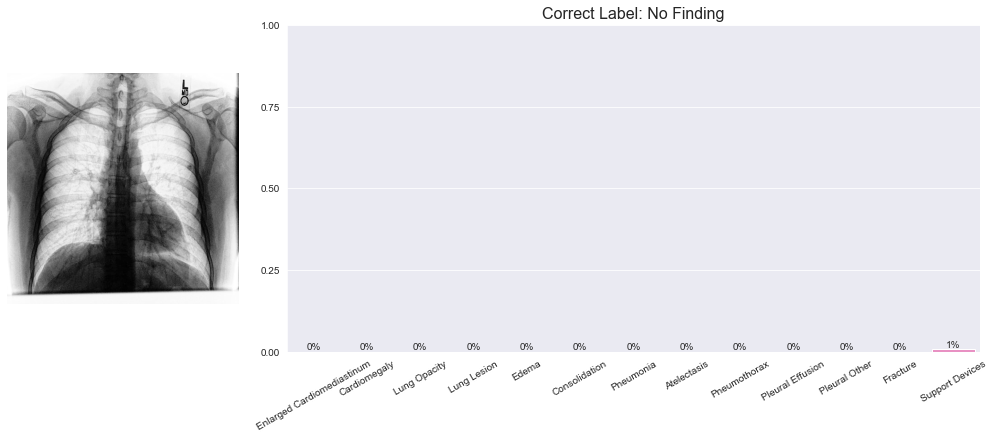

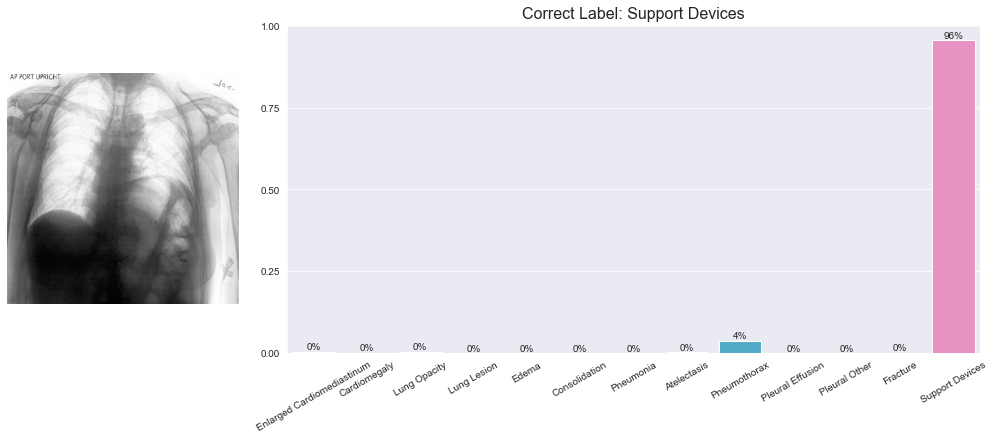

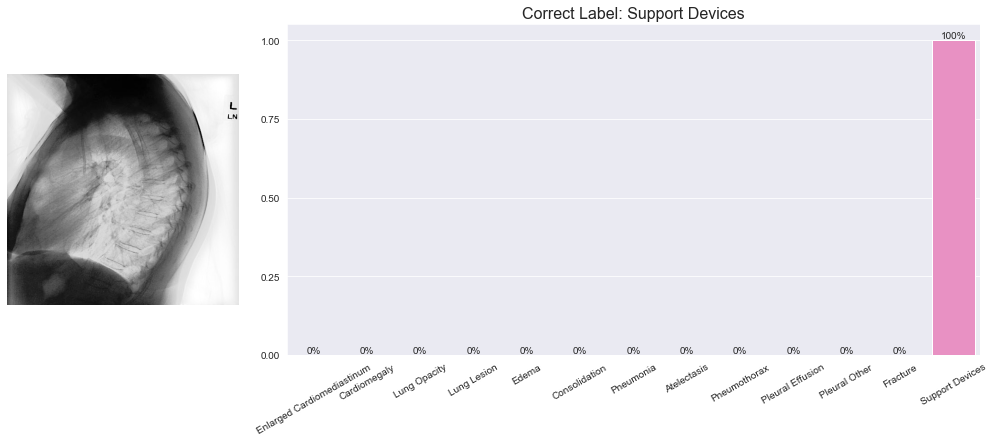

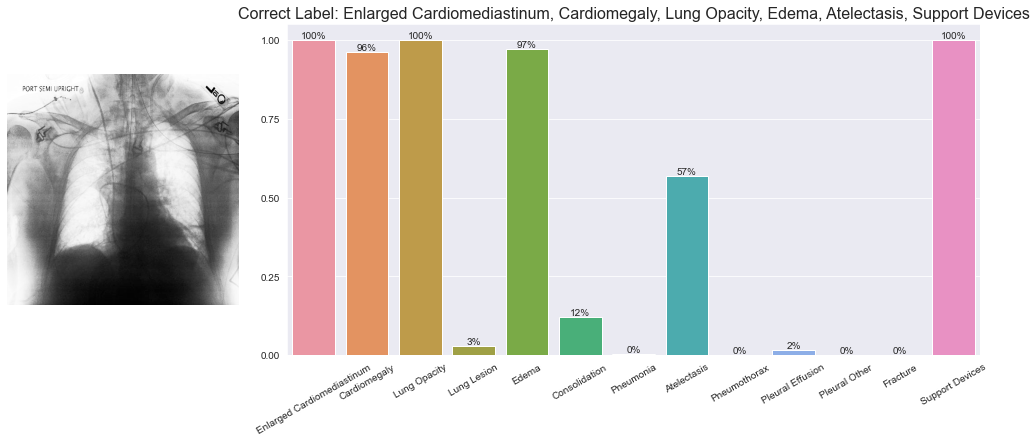

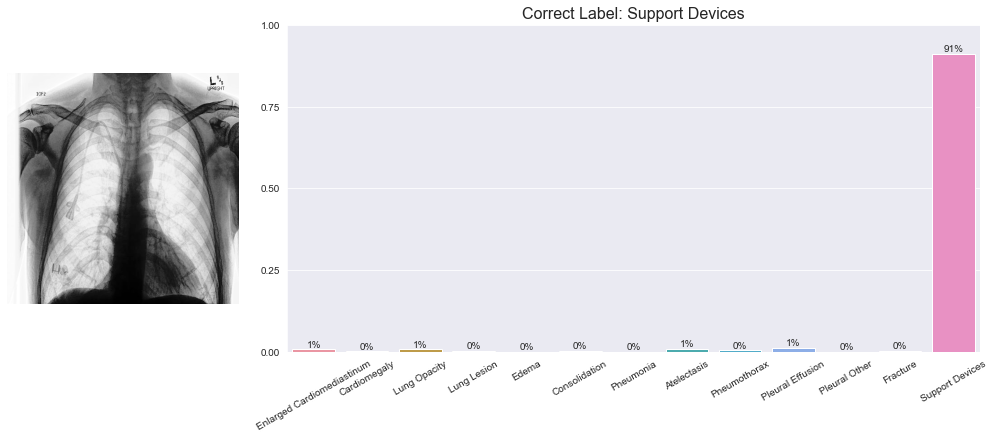

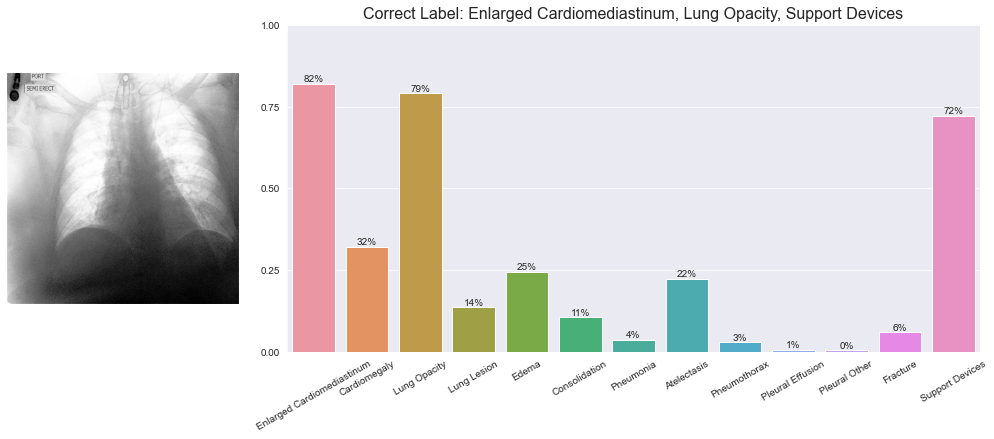

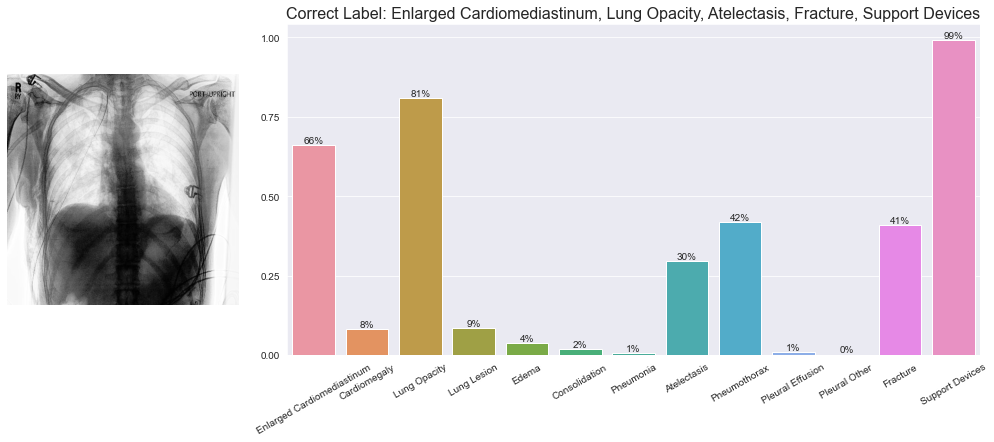

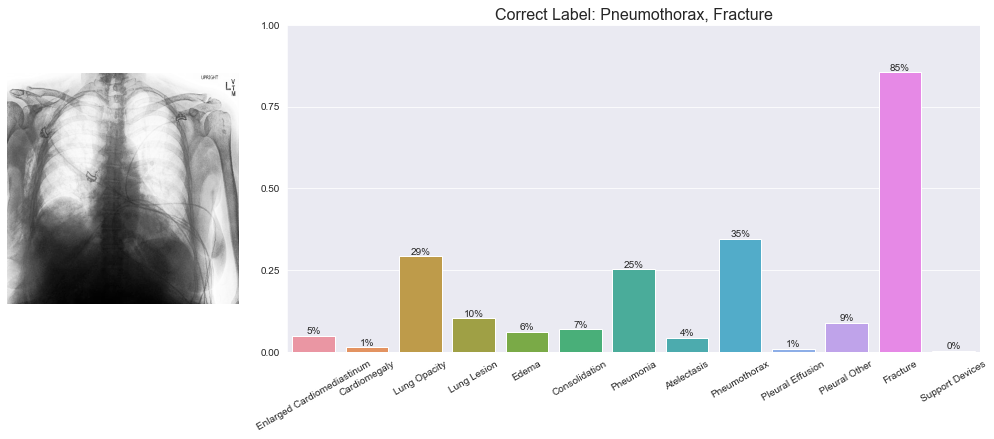

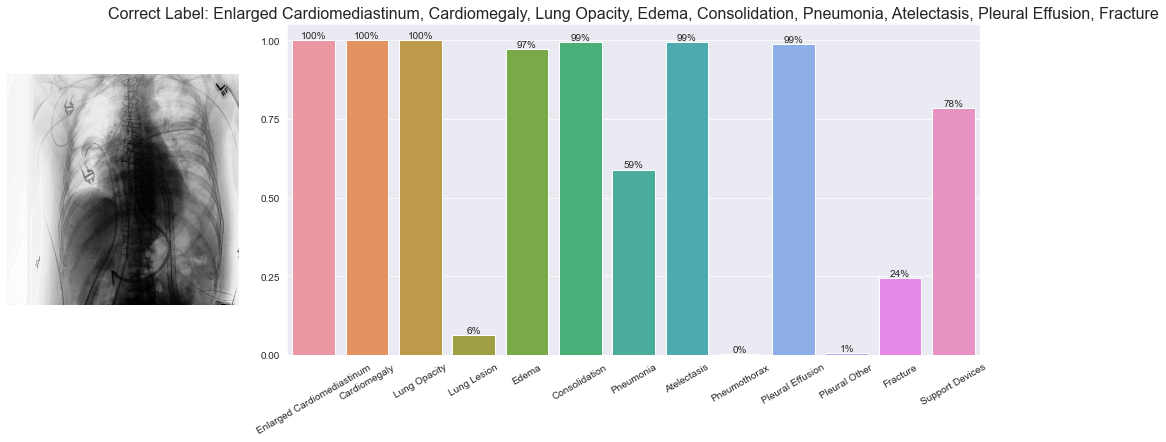

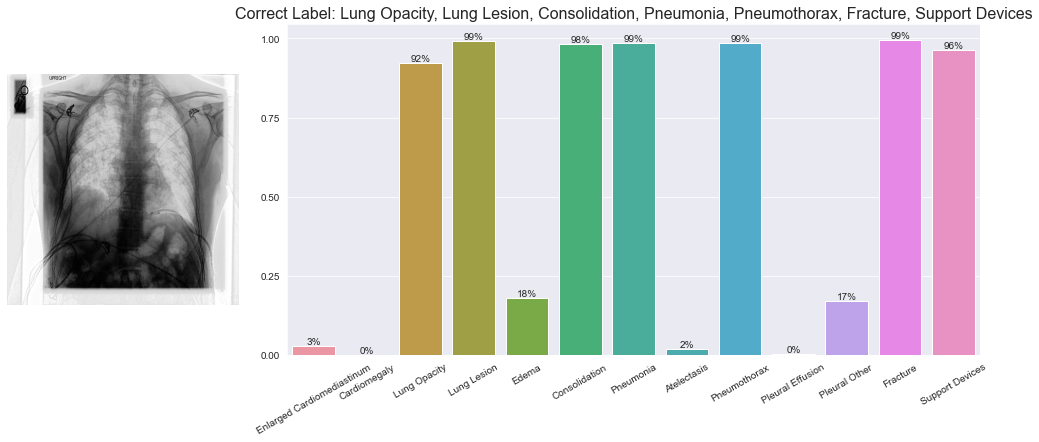

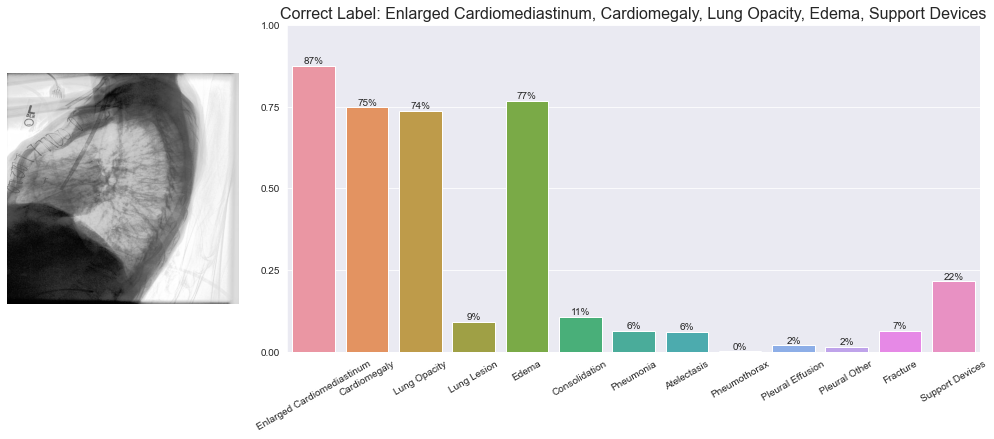

In [10]:
num_samples = 12

samples = random.sample(range(len(train_paths)),num_samples)

images = np.array([extract_image(train_paths[n]) for n in samples])
predictions = model.predict(images,verbose=0)
correct_labels = np.array([train_labels[n] for n in samples])

for i in range(num_samples):
    
    image = images[i]
    correct_label = correct_labels[i]
    if 1 in correct_label:
        correct_classes = [classes[i] for i in np.where(correct_label==1)[0]]
        correct_classes = ', '.join(correct_classes)
    else:
        correct_classes = 'No Finding'
        
    prediction = predictions[i]
    percentages = [(str(i)+'%') for i in (prediction*100).round().astype('int')]
    
    fig,(axis0,axis1) = plt.subplots(1,2,width_ratios=[1,3],figsize=(14,6))
    axis0.imshow(image,cmap='Greys')
    axis0.axis('off')
    bp = sns.barplot(x=pd.Series(classes),y=prediction,label=percentages)
    bp.bar_label(bp.containers[0],labels=percentages)
    plt.xticks(rotation=30,fontsize=10)
    plt.yticks(np.arange(0,1.25,.25))
    plt.tight_layout()
    plt.title('Correct Label: '+correct_classes,fontdict={'fontsize':16})
    plt.show()
    print()

### And here are examples from the test data:

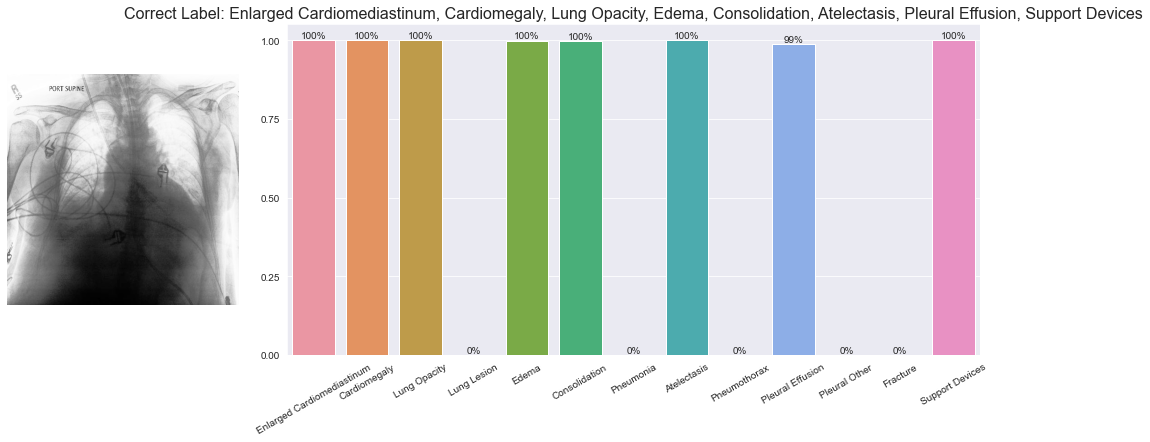

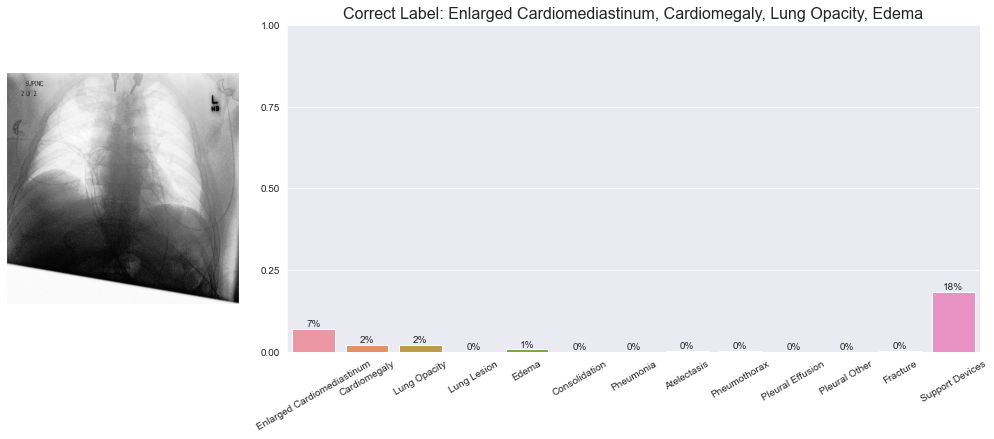

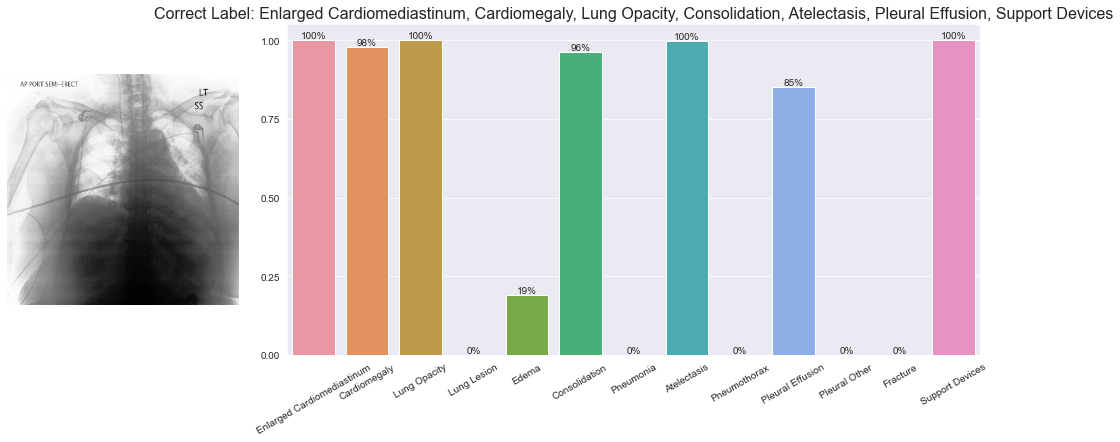

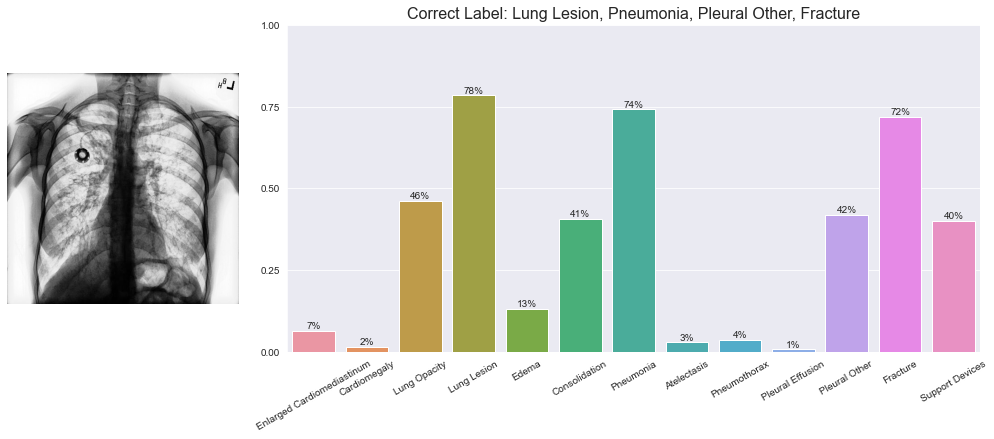

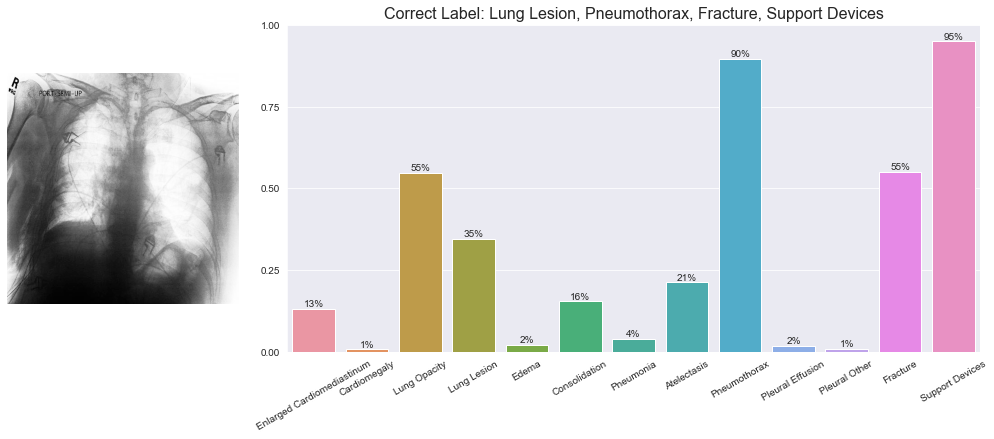

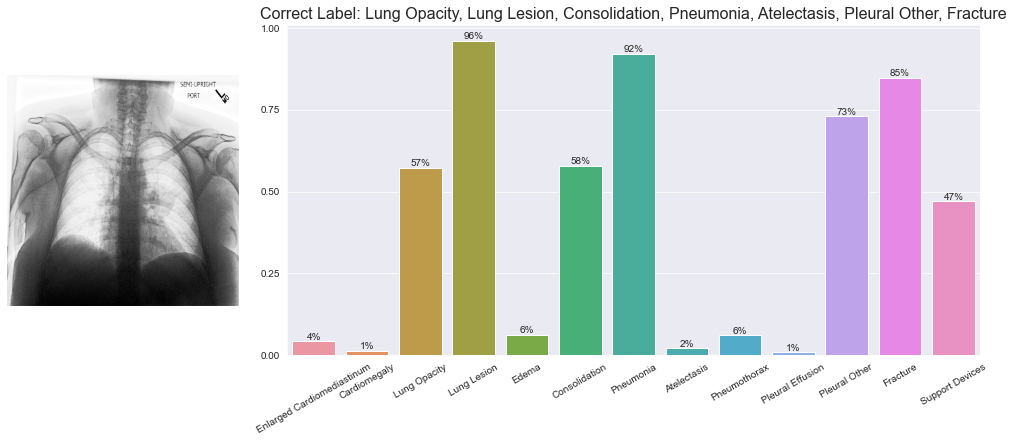

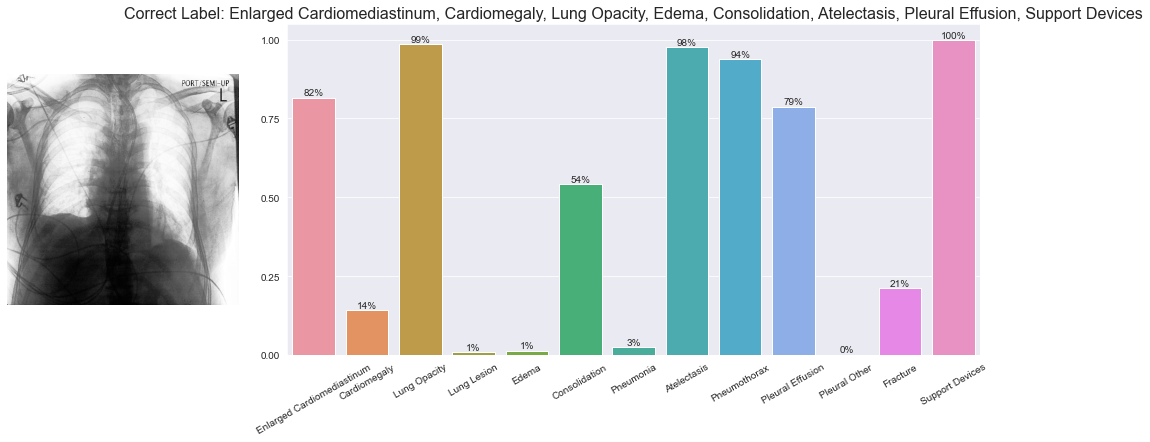

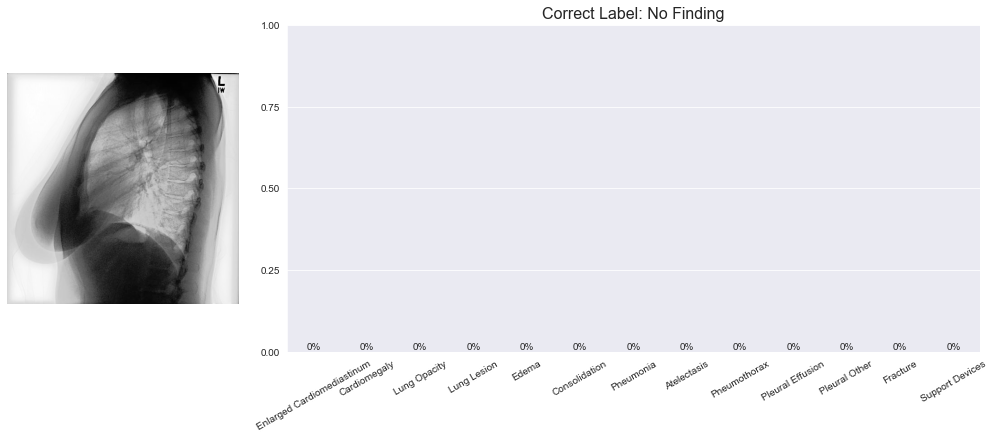

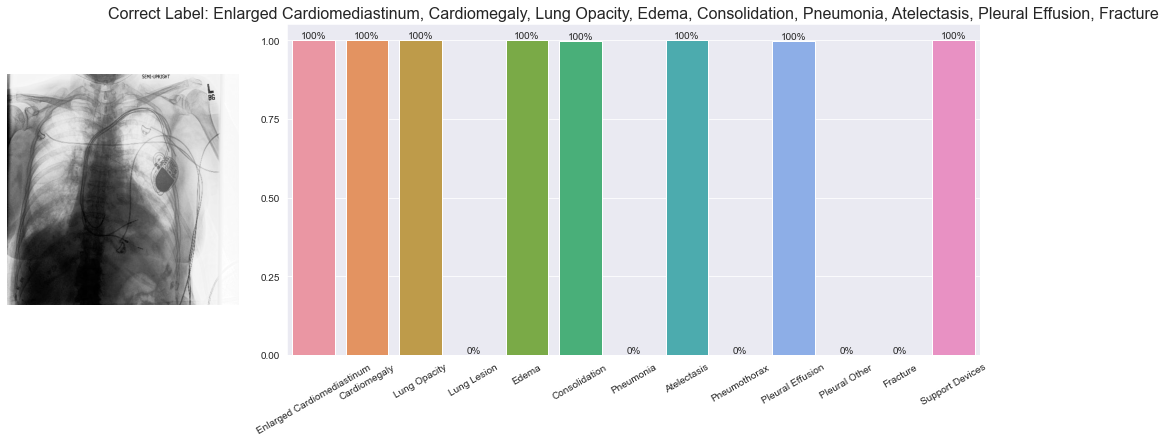

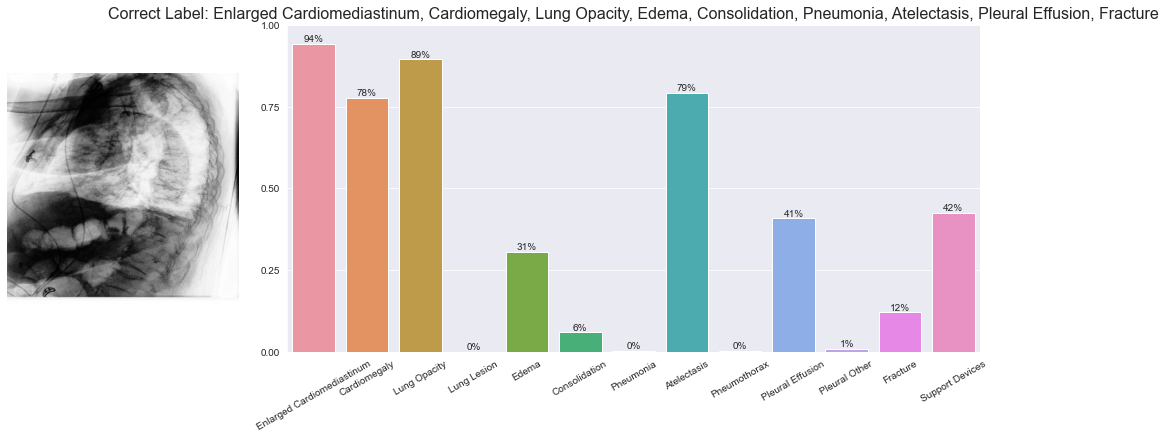

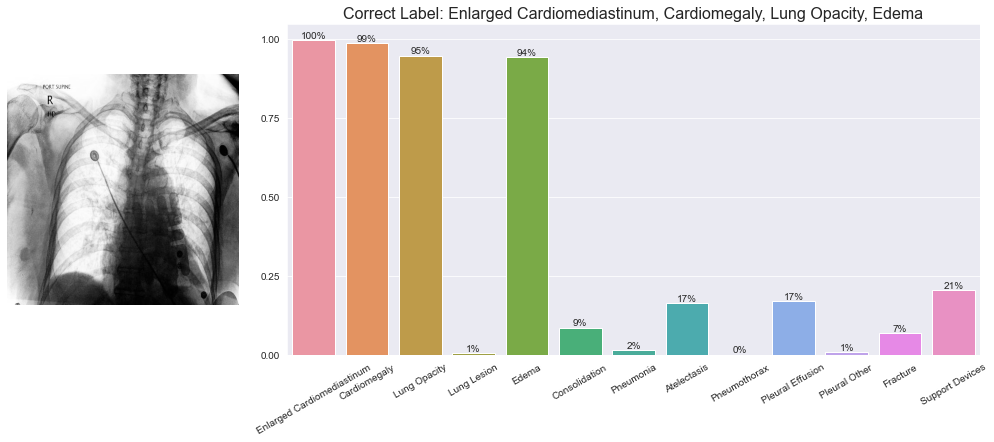

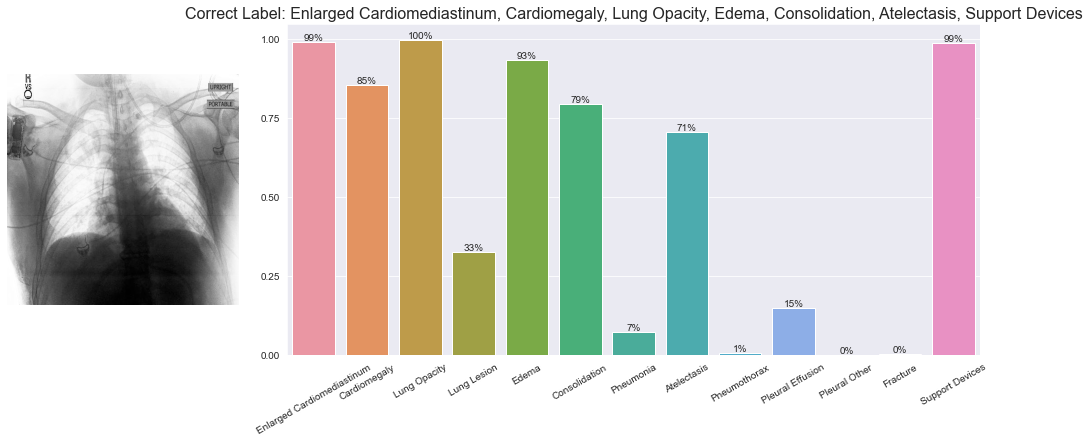

In [11]:
num_samples = 12

samples = random.sample(range(len(test_paths)),num_samples)

images = np.array([extract_image(test_paths[n]) for n in samples])
predictions = model.predict(images,verbose=0)
correct_labels = np.array([test_labels[n] for n in samples])

for i in range(num_samples):
    
    image = images[i]
    correct_label = correct_labels[i]
    if 1 in correct_label:
        correct_classes = [classes[i] for i in np.where(correct_label==1)[0]]
        correct_classes = ', '.join(correct_classes)
    else:
        correct_classes = 'No Finding'
        
    prediction = predictions[i]
    percentages = [(str(i)+'%') for i in (prediction*100).round().astype('int')]
    
    fig,(axis0,axis1) = plt.subplots(1,2,width_ratios=[1,3],figsize=(14,6))
    axis0.imshow(image,cmap='Greys')
    axis0.axis('off')
    bp = sns.barplot(x=pd.Series(classes),y=prediction,label=percentages)
    bp.bar_label(bp.containers[0],labels=percentages)
    plt.xticks(rotation=30,fontsize=10)
    plt.yticks(np.arange(0,1.25,.25))
    plt.tight_layout()
    plt.title('Correct Label: '+correct_classes,fontdict={'fontsize':16})
    plt.show()
    print()